In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [35]:
data=pd.read_csv('data/_auditory_dur_estimate_2024-12-09_11h55.43.030.csv')
# data['is_correct'] = (
#     ((data['test_dur'] > data['standard_dur']) & (data['response'] == data['test_order'])) | 
#     ((data['test_dur'] < data['standard_dur']) & (data['response'] != data['test_order'])) |
#     ((data['test_dur'] == data['standard_dur']) & (data['response'] == np.random.choice([0, 1], size=len(data))))
# ).astype(int)



# 2AFC P Correct

In [ ]:
# Group by both delta_dur and rise_dur
grouped_by_delta_dur_rise_dur = data.groupby(['delta_dur', 'rise_dur'])

# Compute the total responses and correct responses for each condition
summary = grouped_by_delta_dur_rise_dur.agg(
    total_responses=('response', 'count'),
    correct_responses=('is_correct', 'sum')  # Assuming 1 = correct, 0 = incorrect
).reset_index()

# Calculate P(correct)
summary['p_correct'] = summary['correct_responses'] / summary['total_responses']

# Display the summary dataframe
from IPython.display import display

# Display the summary dataframe
display(summary)

# Rise dur =0.1
rise_dur_01 = summary[summary['rise_dur'] == 0.1]
rise_dur_02 = summary[summary['rise_dur'] == 0.2]

# Format the data for each psychometric function as a nx3 matrix
# with columns for the stimulus level, the number of correct responses and the number of total responses.
psychometric_data_rise1 = rise_dur_01[['delta_dur', 'correct_responses', 'total_responses']].values
psychometric_data_rise2 = rise_dur_02[['delta_dur', 'correct_responses', 'total_responses']].values


In [ ]:

result_01 = ps.psignifit(psychometric_data_rise1,  experiment_type='2AFC')
result_02 = ps.psignifit(psychometric_data_rise2,  experiment_type='2AFC')


In [ ]:
print(result_01.parameter_estimate)
plt.figure()
psigniplot.plot_psychometric_function(result_01, plot_data=True)
psigniplot.plot_psychometric_function(result_02, plot_data=True, line_color='red',data_color='r')
plt.show()

# Psignifit fitting Yes No P choice

In [44]:
import psignifit as ps
from psignifit import psigniplot
# Step 1: Calculate whether participant chose "test" stimulus
data['chose_test'] = (data['response'] == data['test_order']).astype(int)

# Step 2: Group by delta_dur and rise_dur to calculate P(choose test)
grouped = data.groupby(['delta_dur', 'rise_dur']).agg(
    total_responses=('response', 'count'),
    chose_test=('chose_test', 'sum')
).reset_index()

# Calculate the proportion of "test chosen" responses
grouped['p_choose_test'] = grouped['chose_test'] / grouped['total_responses']

# Display the summary dataframe
display(grouped)

# Format the data for Psignifit
psychometric_data_rise1 = grouped[grouped['rise_dur'] == 0.1][['delta_dur', 'chose_test', 'total_responses']].values
psychometric_data_rise2 = grouped[grouped['rise_dur'] == 0.2][['delta_dur', 'chose_test', 'total_responses']].values


# Fit psychometric function using 2AFC
result_01 = ps.psignifit(psychometric_data_rise1, experiment_type='yes/no')
result_02 = ps.psignifit(psychometric_data_rise2, experiment_type='yes/no')



,delta_dur,rise_dur,total_responses,chose_test,p_choose_test
0,-0.40,0.1,40,7,0.175
1,-0.40,0.2,40,5,0.125
2,-0.20,0.1,40,5,0.125
3,-0.20,0.2,40,14,0.350
4,-0.05,0.1,40,8,0.200
5,-0.05,0.2,40,7,0.175
6,0.05,0.1,40,24,0.600
7,0.05,0.2,40,26,0.650
8,0.20,0.1,40,22,0.550
9,0.20,0.2,40,19,0.475


    delta_dur  rise_dur   mean
0       -0.40       0.1  0.175
1       -0.40       0.2  0.125
2       -0.20       0.1  0.125
3       -0.20       0.2  0.350
4       -0.05       0.1  0.200
5       -0.05       0.2  0.175
6        0.05       0.1  0.600
7        0.05       0.2  0.650
8        0.20       0.1  0.550
9        0.20       0.2  0.475
10       0.40       0.1  0.750
11       0.40       0.2  0.725


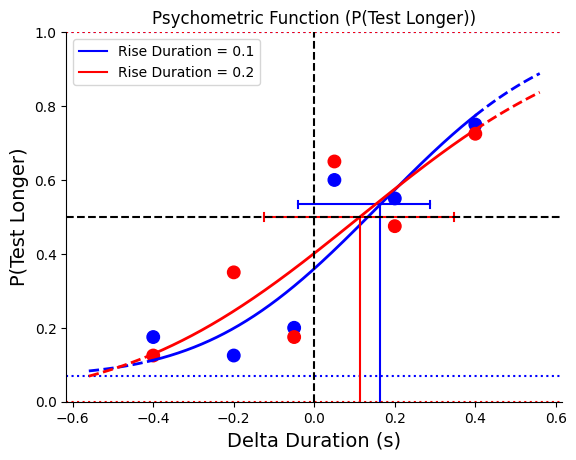

In [37]:

# Plot psychometric function
plt.figure()
psigniplot.plot_psychometric_function(result_01, plot_data=True, line_color='blue', data_color='b') # label rise duration = 0.1
psigniplot.plot_psychometric_function(result_02, plot_data=True, line_color='red', data_color='r') # label rise duration = 0.2

# Customize plot
plt.title('Psychometric Function (P(Test Longer))')
plt.axhline(0.5, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')

plt.xlabel('Delta Duration (s)')
plt.ylabel('P(Test Longer)')

handles =[plt.Line2D([0], [0], color='blue', label='Rise Duration = 0.1'),
            plt.Line2D([0], [0], color='red', label='Rise Duration = 0.2')]
plt.legend(handles=handles)
plt.show()


In [6]:
import numpy as np
from scipy.optimize import curve_fit

# Extract delta durations and responses
x = summary['delta_dur'].values
n_trials = summary['total_responses'].values
n_correct = summary['correct_responses'].values
p_correct = n_correct / n_trials

# Define the logistic function
def logistic(x, mu, sigma):
    return 1 / (1 + np.exp(-(x - mu) / sigma))

# Fit the logistic function to the data
params, _ = curve_fit(logistic, x, p_correct, p0=[0, 0.5])

# Extract the fitted parameters
mu, sigma = params

print(f"Estimated mu: {mu}")
print(f"Estimated sigma: {sigma}")

# Plot the data and the fitted logistic function
x_values = np.linspace(-0.5, 0.5, 1000)
y_values = logistic(x_values, mu, sigma)

plt.figure(figsize=(10, 6))
plt.scatter(x, p_correct, s=n_trials, c='b', alpha=0.5)
plt.plot(x_values, y_values, 'r-', label='Logistic fit')
plt.xlabel('Delta Duration (s)')
plt.ylabel('P(Correct)')
plt.title('Psychometric Function')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'summary' is not defined

Rise Duration 0.1s - λ: 0.2909, μ: 0.1213, σ: 0.2129
Rise Duration 0.2s - λ: 0.0000, μ: 0.1196, σ: 0.5003


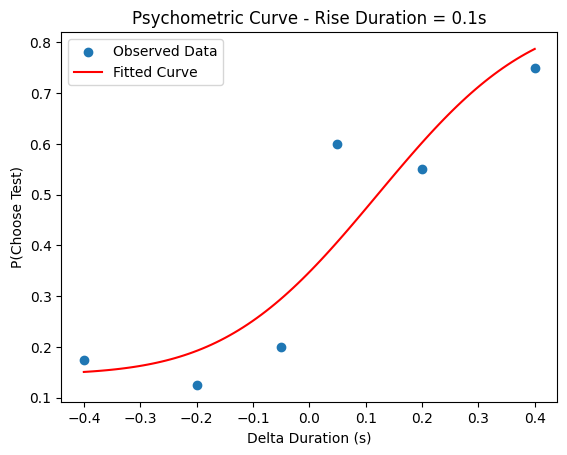

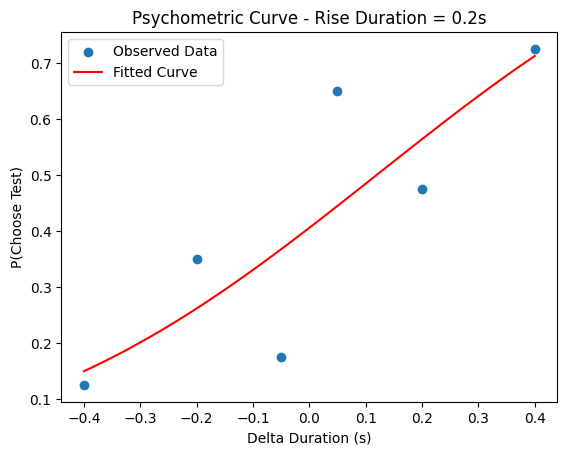

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm

# Load your pilot data
data = pd.read_csv('data/_auditory_dur_estimate_2024-12-09_11h55.43.030.csv')

# Step 1: Prepare the data
data['chose_test'] = (data['response'] == data['test_order']).astype(int)

# Step 2: Group by delta_dur and rise_dur
grouped = data.groupby(['delta_dur', 'rise_dur']).agg(
    total_responses=('response', 'count'),
    chose_test=('chose_test', 'sum')
).reset_index()

# Step 3: Calculate the proportion of "choose test" responses
grouped['p_choose_test'] = grouped['chose_test'] / grouped['total_responses']

# Step 4: Extract data for rise_dur = 0.1 and 0.2
psychometric_data_rise1 = grouped[grouped['rise_dur'] == 0.1][['delta_dur', 'chose_test', 'total_responses']].values
psychometric_data_rise2 = grouped[grouped['rise_dur'] == 0.2][['delta_dur', 'chose_test', 'total_responses']].values


# Define psychometric function
def psychometric_function(delta_dur, lambda_, mu, sigma):
    p = (1 - lambda_) * norm.cdf(delta_dur, loc=mu, scale=sigma) + lambda_ / 2
    return p

# Negative log-likelihood function
def negative_log_likelihood(params, delta_dur, chose_test, total_responses):
    lambda_, mu, sigma = params
    p = psychometric_function(delta_dur, lambda_, mu, sigma)
    epsilon = 1e-9  # To prevent log(0)
    p = np.clip(p, epsilon, 1 - epsilon)
    log_likelihood = np.sum(chose_test * np.log(p) + (total_responses - chose_test) * np.log(1 - p))
    return -log_likelihood

# Fit psychometric curve for a given dataset (rise_dur = 0.1)
def fit_psychometric_curve(data):
    delta_dur = data[:, 0]
    chose_test = data[:, 1]
    total_responses = data[:, 2]
    
    # Initial guess and bounds for [lambda, mu, sigma]
    initial_guess = [0.05, 0, 0.1]  # Initial guesses for [lambda, mu, sigma]
    bounds = [(0, 1), (-1, 1), (0.01, 1)]  # lambda ∈ [0,1], mu ∈ [-1,1], sigma > 0
    
    result = minimize(negative_log_likelihood, initial_guess, 
                      args=(delta_dur, chose_test, total_responses), 
                      bounds=bounds)
    lambda_hat, mu_hat, sigma_hat = result.x
    return lambda_hat, mu_hat, sigma_hat

# Fit parameters for rise_dur = 0.1
lambda_r1, mu_r1, sigma_r1 = fit_psychometric_curve(psychometric_data_rise1)
print(f"Rise Duration 0.1s - λ: {lambda_r1:.4f}, μ: {mu_r1:.4f}, σ: {sigma_r1:.4f}")

# Fit parameters for rise_dur = 0.2
lambda_r2, mu_r2, sigma_r2 = fit_psychometric_curve(psychometric_data_rise2)
print(f"Rise Duration 0.2s - λ: {lambda_r2:.4f}, μ: {mu_r2:.4f}, σ: {sigma_r2:.4f}")

# Plot the results
def plot_psychometric_curve(delta_dur, chose_test, total_responses, lambda_, mu, sigma, rise_dur):
    p_hat = chose_test / total_responses
    plt.scatter(delta_dur, p_hat, label='Observed Data')
    
    delta_dur_range = np.linspace(min(delta_dur), max(delta_dur), 100)
    p_curve = psychometric_function(delta_dur_range, lambda_, mu, sigma)
    plt.plot(delta_dur_range, p_curve, label='Fitted Curve', color='red')
    
    plt.xlabel('Delta Duration (s)')
    plt.ylabel('P(Choose Test)')
    plt.title(f'Psychometric Curve - Rise Duration = {rise_dur}s')
    plt.legend()
    plt.show()

# Plot the psychometric curves for both rise durations
plot_psychometric_curve(psychometric_data_rise1[:, 0], 
                        psychometric_data_rise1[:, 1], 
                        psychometric_data_rise1[:, 2], 
                        lambda_r1, mu_r1, sigma_r1, 
                        rise_dur=0.1)

plot_psychometric_curve(psychometric_data_rise2[:, 0], 
                        psychometric_data_rise2[:, 1], 
                        psychometric_data_rise2[:, 2], 
                        lambda_r2, mu_r2, sigma_r2, 
                        rise_dur=0.2)
